In [1]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.Classify import SklearnClassifier
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
nltk.download('punkt')
nltk.download('popular')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/bryan/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_rev

True

In [19]:
import timeit

def create_df():
    header = ['id', 'tweet', 'target']

    df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')

    df = df.drop('id', axis=1)

    return df

timeit.Timer(create_df).timeit(number=1) * 1000

89.03570300026331

# Extract Dataset

In [2]:
header = ['id', 'tweet', 'target']

tweet_df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')
suicide_df = pd.read_csv('Suicide_Detection.csv', names=header, header=0, encoding='latin-1')

tweet_df = tweet_df.drop('id', axis=1)

suicide_df = suicide_df.drop('id', axis=1)
suicide_df['target'] = suicide_df['target'].map({'suicide': 1, 'non-suicide': 0})

df = pd.concat([tweet_df, suicide_df], ignore_index=True, sort=False)

df

,tweet,target
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
242383,If you don't like rock then your not going to ...,0
242384,You how you can tell i have so many friends an...,0
242385,pee probably tastes like salty teaðð¦â¼ï...,0
242386,The usual stuff you find hereI'm not posting t...,1


In [3]:
df.describe()

,target
count,242388.000000
mean,0.488271
std,0.499863
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


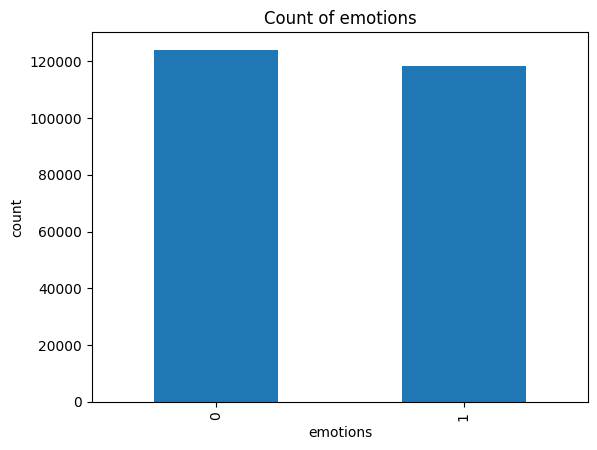

In [14]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

## Tokenize words

In [16]:
raw_token = word_tokenize(example)
raw_token

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/bryan/nltk_data'
    - '/home/bryan/repos/sentimental_analysis/env/nltk_data'
    - '/home/bryan/repos/sentimental_analysis/env/share/nltk_data'
    - '/home/bryan/repos/sentimental_analysis/env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


## Clean Dataset

In [3]:
import string
import re
stopwords = set(nltk.corpus.stopwords.words('english'))

# token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

def clean_words(words):
    table = str.maketrans('', '', string.punctuation)
    splitted_words = words.split()

    lower_split = [w for w in splitted_words if "@" not in w]
    lower_split = [w for w in lower_split if "#" not in w]
    lower_split = [w for w in lower_split if "http" not in w]
    
    lower_split = [w.strip() for w in lower_split]
    lower_split = [w for w in lower_split if not w.isdigit()]
    lower_split = [w for w in lower_split if w.isalpha()]

    lower_split = [w.translate(table) for w in lower_split]

    stopwords_removed_token = [w for w in lower_split if not w in stopwords]
    token = [PorterStemmer().stem(w) for w in stopwords_removed_token]

    token = " ".join(str(x) for x in token)
    return token

df['tweet'] = df['tweet'].apply(lambda x: clean_words(x))

df.head(10)

,tweet,target
0,real good missssssssss,0
1,read manga,0
2,,0
3,need send account i even refer those support,0
4,add me on,0
5,good time tonight though,0
6,someon alreadi fiber home mean least regular,0
7,possibl nice,0
8,nite twittervil workout,0
9,sweet dream,0


# Splitting data for testing and training

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size=0.3, random_state=100, shuffle=True)

# MNB

In [5]:
count_vect = CountVectorizer()
count_mnb_clf = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

In [6]:
cv_result = cross_validate(count_mnb_clf, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision'], cv=6, n_jobs=-1)
print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())

cv_result

0.8930242978747498
0.947579852191682
0.8890853102881499
0.8444241655498104


{'fit_time': array([46.19995332, 44.98616481, 51.04315734, 44.4626658 , 46.21345425,
        45.81349254]),
 'score_time': array([8.09528923, 9.3022449 , 7.50967669, 8.02172971, 9.20364571,
        8.27462697]),
 'test_f1': array([0.89516404, 0.89605047, 0.89342837, 0.88992417, 0.89477285,
        0.88880589]),
 'test_recall': array([0.9499819 , 0.94592834, 0.94817228, 0.94722745, 0.94672072,
        0.94744843]),
 'test_accuracy': array([0.89129743, 0.89278263, 0.88949397, 0.88552939, 0.89122286,
        0.88418559]),
 'test_precision': array([0.84632747, 0.85116915, 0.84466082, 0.8391586 , 0.84822934,
        0.83699962])}

## Learning Curve

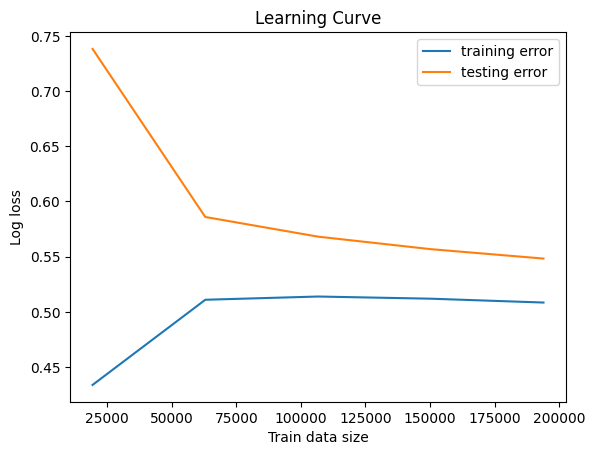

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_mnb_clf, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=5, scoring='neg_log_loss', random_state=100, return_times=True, n_jobs=-1)

plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')

plt.xlabel("Train data size")
plt.ylabel("Log loss")

plt.title("Learning Curve")
plt.legend()

# SVC

In [5]:
count_vect = CountVectorizer()
count_svc_pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', SVC())
])

count_svc_pipeline

Pipeline(steps=[('count_vect', CountVectorizer()), ('clf', SVC())])

In [6]:
cv_result = cross_validate(count_svc_pipeline, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision', 'balanced_accuracy'], cv=6, n_jobs=-1)

print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())
print(cv_result['test_balanced_accuracy'].mean())

cv_result

0.8829208861743773
0.8338601897784645
0.8919673896467603
0.9381236793978721
0.8906634233014281


{'fit_time': array([4221.74483204, 4129.13368154, 4101.72364306, 4171.33611751,
        4483.28495622, 4313.34479713]),
 'score_time': array([428.3322742 , 536.11007166, 442.98605132, 509.06189108,
        338.67927337, 426.5436914 ]),
 'test_f1': array([0.88259886, 0.8849402 , 0.88249732, 0.88349329, 0.88500058,
        0.87899508]),
 'test_recall': array([0.83286283, 0.83814694, 0.83286283, 0.83632547, 0.83480527,
        0.8281578 ]),
 'test_accuracy': array([0.89175713, 0.89352523, 0.89165105, 0.89224839, 0.89401655,
        0.88860598]),
 'test_precision': array([0.93865231, 0.93726728, 0.93842264, 0.93629954, 0.94161836,
        0.93648195]),
 'test_balanced_accuracy': array([0.89043584, 0.89228282, 0.89033213, 0.89099183, 0.8926861 ,
        0.88725182])}

## Learning Curve

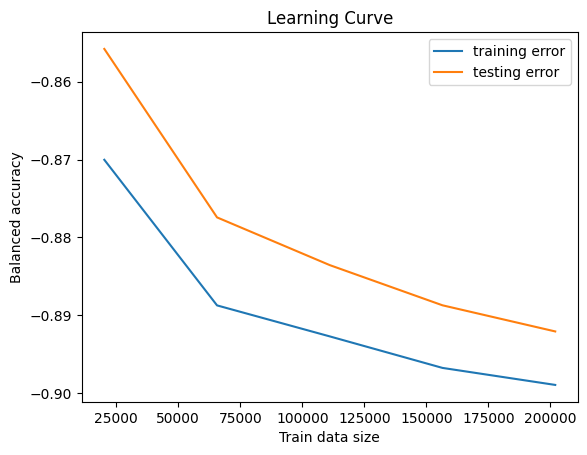

In [7]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_svc_pipeline, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=6, scoring='balanced_accuracy', random_state=100, return_times=True, n_jobs=-1)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()

# Random Forest Classifier

In [6]:
count_vect = CountVectorizer()
count_rf_pipeline = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

In [7]:
cv_result = cross_validate(count_rf_pipeline, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision'], cv=5, n_jobs=-1)

print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())

cv_result

0.8829443677344425
0.9030016479612177
0.8830324518436793
0.8637637223204727


{'fit_time': array([1870.01662087, 1784.68627858, 2006.48498487, 1883.22730637,
        2010.15450501]),
 'score_time': array([7.2142458 , 9.46049213, 4.91327381, 6.08490038, 4.13853073]),
 'test_f1': array([0.88359726, 0.88276025, 0.88078145, 0.88483527, 0.88274761]),
 'test_recall': array([0.90203885, 0.9036617 , 0.90293781, 0.90559778, 0.90077211]),
 'test_accuracy': array([0.88389568, 0.88274297, 0.88059174, 0.88483527, 0.8830966 ]),
 'test_precision': array([0.86589461, 0.86280382, 0.85968641, 0.86500346, 0.86543031])}

## Learning Curve

/home/bryan/repos/sentimental_analysis/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


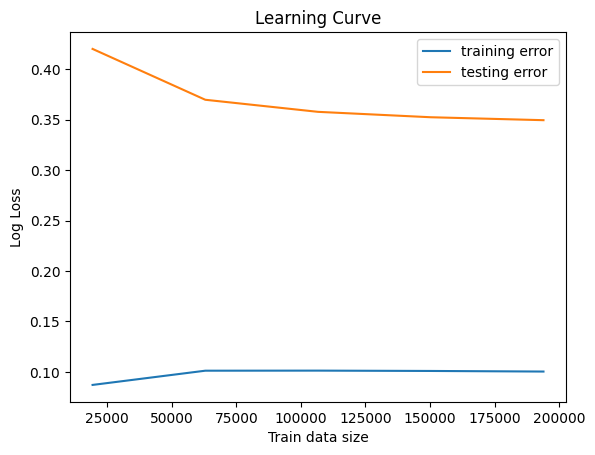

In [8]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
import numpy as np

# print(np.linspace(1, 45000, 100))
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_rf_pipeline, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=5, scoring='neg_log_loss', random_state=100, return_times=True, n_jobs=-1)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Log Loss")
plt.legend()